<a href="https://colab.research.google.com/github/Rahafhosari/DataScience2024-2025/blob/master/arima_models_core.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ARIMA Models
Name : Rahaf

# Mount

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Imports

In [ ]:
!pip install numpy==1.25.2
!pip install pandas==2.0.3
#To solve "from pmdarima.model_selection import train_test_split" import problem

In [ ]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import os
import statsmodels.tsa.api as tsa
from pmdarima.model_selection import train_test_split
from pmdarima.arima.utils import ndiffs

# Set wide fig size for plots
plt.rcParams['figure.figsize']=(12,3)

# Helper Functions

## Plot Forcast

In [ ]:
def plot_forecast(ts_train, ts_test, forecast_df, n_train_lags=None,
                  figsize=(10,4), title='Comparing Forecast vs. True Data'):
    ### PLot training data, and forecast (with upper/,lower ci)
    fig, ax = plt.subplots(figsize=figsize)

    # setting the number of train lags to plot if not specified
    if n_train_lags==None:
        n_train_lags = len(ts_train)

    # Plotting Training  and test data
    ts_train.iloc[-n_train_lags:].plot(ax=ax, label="train")
    ts_test.plot(label="test", ax=ax)

    # Plot forecast
    forecast_df['mean'].plot(ax=ax, color='green', label="forecast")

    # Add the shaded confidence interval
    ax.fill_between(forecast_df.index,
                    forecast_df['mean_ci_lower'],
                   forecast_df['mean_ci_upper'],
                   color='green', alpha=0.3,  lw=2)

    # set the title and add legend
    ax.set_title(title)
    ax.legend();

    return fig, ax

## Augmented Dickey-Fuller Test

In [ ]:
# Custom function for Ad Fuller Test
def get_adfuller_results(ts, alpha=.05, label='adfuller', **kwargs): #kwargs for adfuller()
    # Saving each output
    (test_stat, pval, nlags, nobs, crit_vals_d,
    icbest ) = tsa.adfuller(ts, **kwargs)
    # Converting output to a dictionary with the interpretation of p
    adfuller_results = {'Test Statistic': test_stat,
                        "# of Lags Used":nlags,
                       '# of Observations':nobs,
                        'p-value': round(pval,6),
                        'alpha': alpha,
                       'sig/stationary?': pval < alpha}
    return pd.DataFrame(adfuller_results, index =[label])

## Regression Metrics with MAPE

In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, mean_absolute_percentage_error

def regression_metrics_ts(ts_true, ts_pred, label="", verbose=True, output_dict=False,):
    # Get metrics
    mae = mean_absolute_error(ts_true, ts_pred)
    mse = mean_squared_error(ts_true, ts_pred)
    rmse = mean_squared_error(ts_true, ts_pred, squared=False)
    r_squared = r2_score(ts_true, ts_pred)
    mae_perc = mean_absolute_percentage_error(ts_true, ts_pred) * 100

    if verbose == True:
        # Print Result with label
        header = "---" * 20
        print(header, f"Regression Metrics: {label}", header, sep="\n")
        print(f"- MAE = {mae:,.3f}")
        print(f"- MSE = {mse:,.3f}")
        print(f"- RMSE = {rmse:,.3f}")
        print(f"- R^2 = {r_squared:,.3f}")
        print(f"- MAPE = {mae_perc:,.2f}%")

    if output_dict == True:
        metrics = {
            "Label": label,
            "MAE": mae,
            "MSE": mse,
            "RMSE": rmse,
            "R^2": r_squared,
            "MAPE(%)": mae_perc,
        }
        return metrics

## Sig Lags

In [ ]:
def get_sig_lags(ts, type='ACF',  nlags=None,alpha=0.5):


    if type == 'ACF':
        # Running the function used by plot_acf
        corr_values, conf_int = tsa.stattools.acf(ts, alpha=alpha, nlags=nlags)

    elif type=='PACF':
        corr_values, conf_int = tsa.stattools.pacf(ts, alpha=alpha, nlags=nlags)

    else:
        raise Exception("type must be either 'ACF' or 'PACF'")

    # Determine lags
    lags =range(len(corr_values))

    # Create a centered version of the acf_df
    corr_df = pd.DataFrame({type:corr_values,
                            'Lags':lags,
                            'lower ci': conf_int[:,0]-corr_values, # subtract acf from lower ci to center
                            'upper ci': conf_int[:,1]-corr_values, # subtact acf to upper ci to center
                                 })
    corr_df = corr_df.set_index("Lags")

    # Getting filter for sig lags
    filter_sig_lags = (corr_df[type] < corr_df['lower ci']) | (corr_df[type] > corr_df['upper ci'])

    # Get lag #'s
    sig_lags= corr_df.index[filter_sig_lags]
    sig_lags = sig_lags[sig_lags!=0]

    return sig_lagscopy

## Combined ACF/PACF

In [ ]:
def plot_acf_pacf(ts, nlags=40, figsize=(10, 5),
                  annotate_sig=False, alpha=.05,
                 acf_kws={}, pacf_kws={},
                  annotate_seas=False, m = None,
                 seas_color='black'):

    fig, axes = plt.subplots(nrows=2, figsize=figsize)

    # Sig lags line style
    sig_vline_kwargs = dict( ls=':', lw=1, zorder=0, color='red')
    # ACF
    tsa.graphics.plot_acf(ts, ax=axes[0], lags=nlags, **acf_kws)

    ## Annotating sig acf lags
    if annotate_sig == True:
        sig_acf_lags = get_sig_lags(ts,nlags=nlags,alpha=alpha, type='ACF')
        for lag in sig_acf_lags:
            axes[0].axvline(lag,label='sig', **sig_vline_kwargs )
    # PACF
    tsa.graphics.plot_pacf(ts,ax=axes[1], lags=nlags, **pacf_kws)

    ## Annotating sig pacf lags
    if annotate_sig == True:
        ## ANNOTATING SIG LAGS
        sig_pacf_lags = get_sig_lags(ts,nlags=nlags,alpha=alpha, type='PACF')
        for lag in sig_pacf_lags:
            axes[1].axvline(lag, label='sig', **sig_vline_kwargs)

    ### ANNOTATE SEASONS
    if annotate_seas == True:
        # Ensure m was defined
        if m is None:
            raise Exception("Must define value of m if annotate_seas=True.")
        ## Calculate number of complete seasons to annotate
        n_seasons = nlags//m
        # Seasonal Lines style
        seas_vline_kwargs = dict( ls='--',lw=1, alpha=.7, color=seas_color, zorder=-1)

        ## for each season, add a line
        for i in range(1, n_seasons+1):
            axes[0].axvline(m*i, **seas_vline_kwargs, label="season")
            axes[1].axvline(m*i, **seas_vline_kwargs, label="season")
    fig.tight_layout()

    return fig

# Load Data

In [ ]:
path = "/content/drive/MyDrive/AXSOSACADEMY/07-TimeSeriesAnalysis/ARIMA & SARIMA/ARIMA CORE/WMT.csv"
ts = pd.read_csv(path,
                  parse_dates=['Date'], index_col='Date')
ts.head()

,Adj Close
Date,
2000-01-03,44.915394
2000-01-04,43.234756
2000-01-05,42.352402
2000-01-06,42.814564
2000-01-07,46.049828


In [ ]:
df = ts.copy()

In [ ]:
df.index

DatetimeIndex(['2000-01-03', '2000-01-04', '2000-01-05', '2000-01-06',
               '2000-01-07', '2000-01-10', '2000-01-11', '2000-01-12',
               '2000-01-13', '2000-01-14',
               ...
               '2020-12-18', '2020-12-21', '2020-12-22', '2020-12-23',
               '2020-12-24', '2020-12-25', '2020-12-28', '2020-12-29',
               '2020-12-30', '2020-12-31'],
              dtype='datetime64[ns]', name='Date', length=5479, freq=None)

In [ ]:
df = df.loc['2010-01-01':'2020-12-31']

In [ ]:
df.index = pd.to_datetime(df.index)
df.index

DatetimeIndex(['2010-01-01', '2010-01-04', '2010-01-05', '2010-01-06',
               '2010-01-07', '2010-01-08', '2010-01-11', '2010-01-12',
               '2010-01-13', '2010-01-14',
               ...
               '2020-12-18', '2020-12-21', '2020-12-22', '2020-12-23',
               '2020-12-24', '2020-12-25', '2020-12-28', '2020-12-29',
               '2020-12-30', '2020-12-31'],
              dtype='datetime64[ns]', name='Date', length=2870, freq=None)

Make a datetime index using the Date column with a business day frequency ('B')

In [ ]:
# prompt: Date column with a business day frequency ('B')
df.index.freq= "B"
# # Make a datetime index using the Date column with a business day frequency ('B')
# df.index = pd.date_range(start='2010', periods=len(df), freq='B')

In [ ]:
df.head(-5)

,Adj Close
Date,
2010-01-01,NaN
2010-01-04,40.963638
2010-01-05,40.555729
2010-01-06,40.465084
2010-01-07,40.487759
...,...
2020-12-18,143.665359
2020-12-21,143.685059
2020-12-22,141.942734


In [ ]:
#Check for and address null values.
df.isnull().sum()

,0
Adj Close,101


## Inspect Null Values

<Axes: xlabel='Date'>

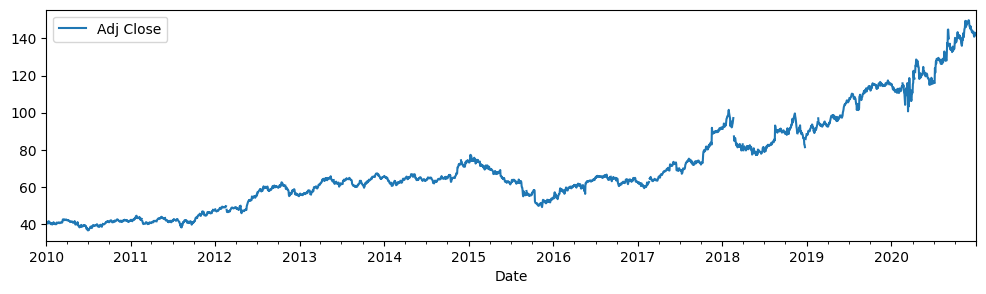

In [ ]:
df.plot(figsize=(12,3))

> Make Plot with day frequency instead of year as major locator

In [ ]:
null = df.isna()
df[null].head(101)

,Adj Close
Date,
2010-01-01,NaN
2010-01-04,NaN
2010-01-05,NaN
2010-01-06,NaN
2010-01-07,NaN
...,...
2010-05-17,NaN
2010-05-18,NaN
2010-05-19,NaN


> We can inspec that null vlaues are data from 2010-01-01 till 2010-05-21

> TODO: Missing values are consistent --> Remove all nulls

For missing values in stocks market
the missing value for holidays is subs. with the day before.

> Remove 01/01/2010 and do ffill since we have a value in 02-01-2010

1- Remove Weekends since the sotocks market closes on the Weekends

In [ ]:
df.index.weekday

Index([4, 0, 1, 2, 3, 4, 0, 1, 2, 3,
       ...
       4, 0, 1, 2, 3, 4, 0, 1, 2, 3],
      dtype='int32', name='Date', length=2870)

In [ ]:
# Remove weekends (Saturday and Sunday)
df = df[df.index.weekday < 5]

In [ ]:
df.isnull().sum()

,0
Adj Close,101


In [ ]:
len(df) ## 2870 remaining columns from originally 5479 columns

2870

> Null Values aren't in the Weekends

>TODO : Keep DF with Business Day Frequency

2- Remove Holidays

In [ ]:
import holidays

# Generate US holidays for the years in your data
us_holidays = holidays.US(years=range(2010, 2021))

# Filter out holidays
df = df[~df.index.isin(us_holidays)]

In [ ]:
len(df) ## 2760 remaining columns from originally 2870 columns after removing weekends

2760

In [ ]:
df.isnull().sum()

,0
Adj Close,14


> Null Value are now 14 values.
Use Interpolation

In [ ]:
df['Adj Close'] = df['Adj Close'].interpolate(method='linear')

In [ ]:
df.isnull().sum()

,0
Adj Close,0


#Check Stationary

In [ ]:
# Testing the raw data for stationarity
get_adfuller_results(df)

,Test Statistic,# of Lags Used,# of Observations,p-value,alpha,sig/stationary?
adfuller,1.518672,19,2740,0.997592,0.05,False


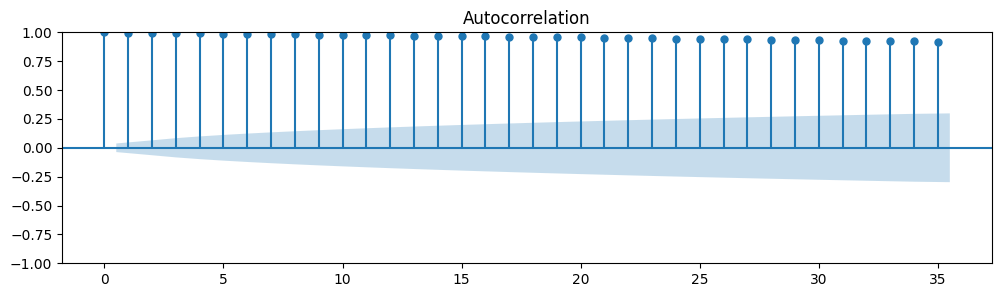

In [ ]:
fig = tsa.graphics.plot_acf(df);

In [ ]:
get_adfuller_results(df)

,Test Statistic,# of Lags Used,# of Observations,p-value,alpha,sig/stationary?
adfuller,1.518672,19,2740,0.997592,0.05,False


In [ ]:
# use ndiffs to determine differencing
d = ndiffs(df)
print(f'd is {d}')

d is 1


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11

## Make Data Stationary

<Axes: xlabel='Date'>

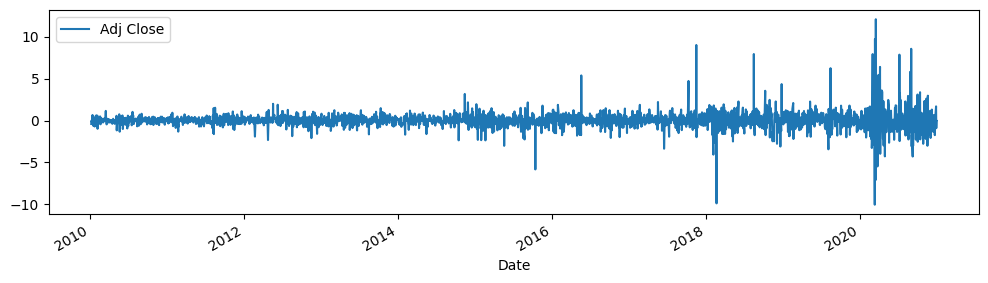

In [ ]:
# Differencing the data once
df_diff = df.diff()
df_diff.plot()

In [ ]:
df_diff = df_diff.dropna()

In [ ]:
# Checking for stationarity
get_adfuller_results(df_diff)

,Test Statistic,# of Lags Used,# of Observations,p-value,alpha,sig/stationary?
adfuller,-13.764443,18,2740,0.0,0.05,True


>Data is now Stationary

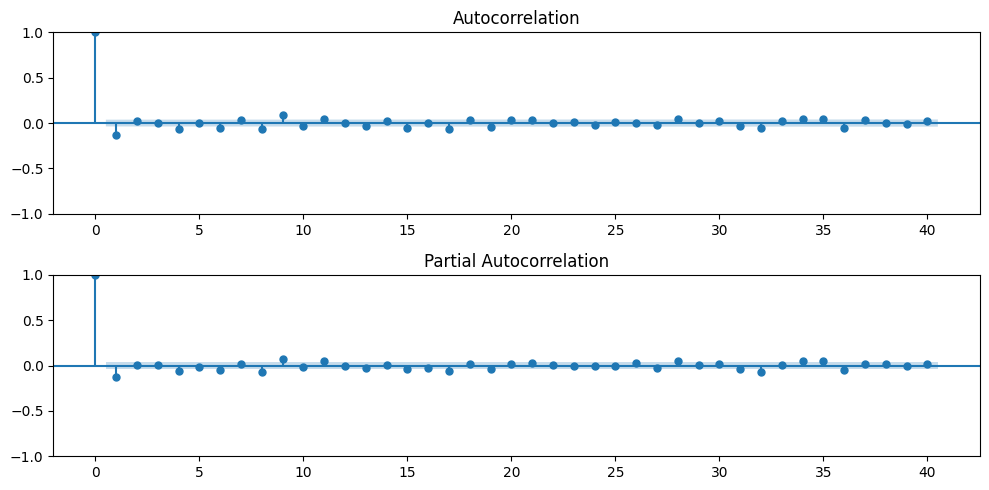

In [ ]:
plot_acf_pacf(df_diff);

> ACF Gradually Decreasing <br/>
> PACF also Gradually Decreasing <br/>
> Model to Choose : ARMA(p,q) <br/>

Train Split Test

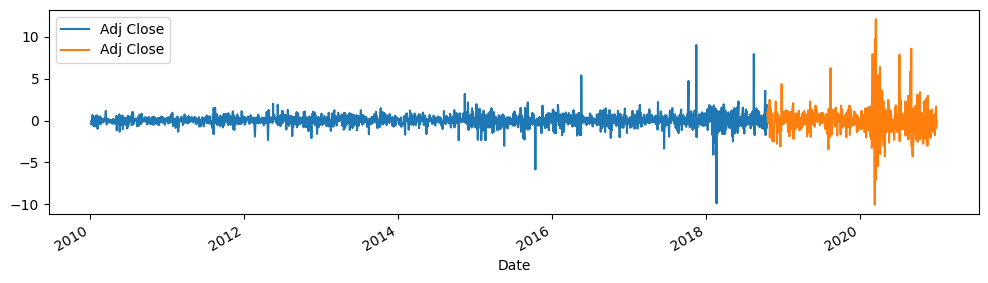

In [ ]:
# tts
train, test = train_test_split(df_diff, test_size=.20)
# Visualize the train and test data
ax = train.plot(label='Train')
test.plot(ax=ax, label='Test')
ax.legend();

Fit Model

In [ ]:
# First define the orders (p,d,q)
p = 1 # p is used for AR component of AR-MA model
d = 1 # 1 differcing needed to make stationary
q = 1 # q is used for MA component of AR-MA model
# Now instantiate the model with the data and fit
ar_ma_model = tsa.ARIMA(train, order = (p,d,q)).fit()
ar_ma_model

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


In [ ]:
ar_ma_model.params

,0
ar.L1,-0.053234
ma.L1,-0.999951
sigma2,0.518341


> Frocast
> Plot Forcast
>Evaluate Metrics